
=== K = 10000, G = 100 ===
Finished all policies for K = 10000

=== K = 50000, G = 80 ===
Finished all policies for K = 50000

=== K = 100000, G = 60 ===
Finished all policies for K = 100000

=== K = 500000, G = 30 ===
Finished all policies for K = 500000

=== K = 1000000, G = 10 ===
Finished all policies for K = 1000000

=== K = 15000000, G = 1 ===
Finished all policies for K = 15000000


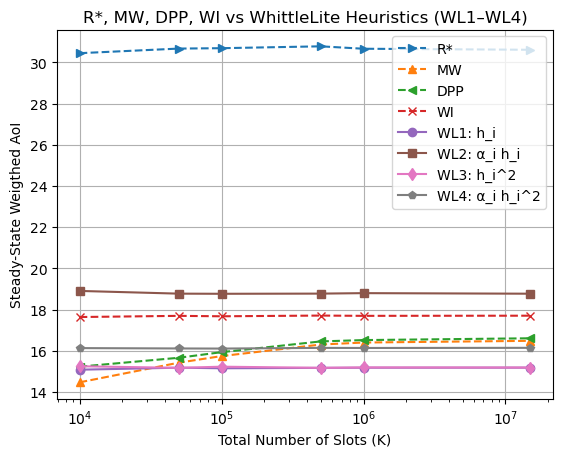

In [2]:
# Worked on memory-efficient simulation framework for the comparison of 
# (1). WhittleLite 1, 2, 3, 4
# (2). Stationary randomized optimal policy R*
# (3). Max-Weight policy
# (4). Drift-plus-Penalty policy
# (5). Whittle Index policy
# Latter 4 policies are similar to that of Justin's simulation, while the first 4 policies are within WhittleLite.
# Same slotted setting with M=15 independent information sources, with a source-dependent probability p_i.
# Monte-Carlo averaging was used.

import numpy as np
import matplotlib.pyplot as plt

# ---------------- Model parameters ---------------- #

M = 15
epsilon = 0.9
V = V_prime = 1

i_nodes = np.arange(1, M+1)

alpha_i = (M + 1 - i_nodes) / M      # importance weights (node 1 highest)
p_i = i_nodes / M                    # success probability per node
q_i = epsilon * p_i / M              # target throughputs (very small)

# ---- R* parameter computation ---- #

gamma_i = alpha_i * p_i / (M * q_i**2)
gamma = np.max(gamma_i)

# shape (M,)
mu_i = q_i / p_i * np.max(
    np.concatenate(
        (np.ones((M, 1)), np.sqrt(gamma_i / gamma).reshape(M, 1)),
        axis=1
    ),
    axis=1
)

S = np.sum(mu_i)
while S < 1:
    gamma -= 0.1
    mu_i = q_i / p_i * np.max(
        np.concatenate(
            (np.ones((M, 1)), np.sqrt(gamma_i / gamma).reshape(M, 1)),
            axis=1
        ),
        axis=1
    )
    S = np.sum(mu_i)

mu_i = np.round(mu_i, 4)
# normalize to a true probability vector for rng.choice
mu_prob = mu_i / np.sum(mu_i)

# ---- WI parameter computation ---- #

chi_i = alpha_i * p_i * ((1.0 / q_i)**2 - (1.0 / p_i - 0.5)**2) / 2.0
C = np.max(chi_i)

phi_i_inv = p_i * np.sqrt(
    2.0 * np.min(
        np.concatenate(
            (C * np.ones((M, 1)), chi_i.reshape(M, 1)),
            axis=1
        ),
        axis=1
    ) / (alpha_i * p_i) + (1.0 / p_i - 0.5)**2
)
S = np.sum(1.0 / phi_i_inv)

while S < 1:
    C -= 0.1
    phi_i_inv = p_i * np.sqrt(
        2.0 * np.min(
            np.concatenate(
                (C * np.ones((M, 1)), chi_i.reshape(M, 1)),
                axis=1
            ),
            axis=1
        ) / (alpha_i * p_i) + (1.0 / p_i - 0.5)**2
    )
    S = np.sum(1.0 / phi_i_inv)

C_star = C
chi_i_star = np.min(
    np.concatenate(
        (C_star * np.ones((M, 1)), chi_i.reshape(M, 1)),
        axis=1
    ),
    axis=1
)
theta_i = C_star - chi_i_star

# ---- cached constants ---- #

alpha_times_p_i = 0.5 * alpha_i * p_i
alpha_div_mu_i = 0.5 * alpha_i / mu_i
two_div_p_i = 2.0 / p_i

# ---------------- Time horizons & Monte Carlo runs ---------------- #

K_values = np.array([10**4, 5*10**4, 10**5, 5*10**5, 10**6, 15*10**6])
G_values = np.array([100, 80, 60, 30, 10, 1])  

# ---------------- Storage for AoI results (8 policies) ---------------- #

R_Star_aoi = np.zeros_like(K_values, dtype=float)
MW_aoi     = np.zeros_like(K_values, dtype=float)
DPP_aoi    = np.zeros_like(K_values, dtype=float)
WI_aoi     = np.zeros_like(K_values, dtype=float)

WL1_aoi    = np.zeros_like(K_values, dtype=float)
WL2_aoi    = np.zeros_like(K_values, dtype=float)
WL3_aoi    = np.zeros_like(K_values, dtype=float)
WL4_aoi    = np.zeros_like(K_values, dtype=float)

# ---------------- Helper: compute J_avg from AoI areas ---------------- #

def compute_J_from_areas(area, last_delivery, K, alpha_i):
    M = len(alpha_i)
    area = area.copy()
    for i in range(M):
        L_tail = K - last_delivery[i]
        area[i] += L_tail * (L_tail + 1) / 2.0

    h_avg = area / K
    J_avg = np.sum(alpha_i * h_avg / M)
    return J_avg

# ---------------- Main simulation loop ---------------- #

rng = np.random.default_rng()

for idx_K in range(len(K_values)):
    G = G_values[idx_K]
    K = K_values[idx_K]

    print(f"\n=== K = {K}, G = {G} ===")

    for g in range(G):

        # ========== R* (stationary randomized) ==========
        last_del_R = np.zeros(M, dtype=int)
        area_R     = np.zeros(M, dtype=float)

        # ========== MW (Max-Weight AoI + debt) ==========
        h_MW       = np.ones(M)
        last_del_MW = np.zeros(M, dtype=int)
        area_MW     = np.zeros(M, dtype=float)

        d_sum_MW   = np.zeros(M)  # cumulative successes
        q_sum_MW   = np.zeros(M)  # cumulative targets
        x_MW       = np.zeros(M)  # throughput debt

        # ========== DPP ==========
        h_DPP       = np.ones(M)
        last_del_DPP = np.zeros(M, dtype=int)
        area_DPP     = np.zeros(M, dtype=float)

        d_sum_DPP   = np.zeros(M)
        q_sum_DPP   = np.zeros(M)
        x_DPP       = np.zeros(M)

        # ========== WI (Whittle Index) ==========
        h_WI       = np.ones(M)
        last_del_WI = np.zeros(M, dtype=int)
        area_WI     = np.zeros(M, dtype=float)

        # ========== WL1–WL4 (AoI heuristics) ==========
        # WL1: W_i = h_i
        h_WL1       = np.ones(M)
        last_del_WL1 = np.zeros(M, dtype=int)
        area_WL1     = np.zeros(M, dtype=float)

        # WL2: W_i = alpha_i * h_i
        h_WL2       = np.ones(M)
        last_del_WL2 = np.zeros(M, dtype=int)
        area_WL2     = np.zeros(M, dtype=float)

        # WL3: W_i = h_i^2
        h_WL3       = np.ones(M)
        last_del_WL3 = np.zeros(M, dtype=int)
        area_WL3     = np.zeros(M, dtype=float)

        # WL4: W_i = alpha_i * h_i^2
        h_WL4       = np.ones(M)
        last_del_WL4 = np.zeros(M, dtype=int)
        area_WL4     = np.zeros(M, dtype=float)

        # -------- Simulate slot by slot -------- #
        for k in range(1, K+1):

            # ----- R*: schedule by mu_prob, success ~ Bernoulli(p_i) -----
            i_sel_R = rng.choice(M, p=mu_prob)  # 0..M-1
            success_R = rng.random() < p_i[i_sel_R]
            if success_R:
                L = k - last_del_R[i_sel_R]
                area_R[i_sel_R] += L * (L + 1) / 2.0
                last_del_R[i_sel_R] = k

            # ----- MW: MaxWeight on AoI & debt -----
            W_MW = alpha_times_p_i * (h_MW**2 + 2*h_MW) + V * p_i * np.where(x_MW > 0, x_MW, 0)
            i_sel_MW = np.argmax(W_MW)
            success_MW = rng.random() < p_i[i_sel_MW]
            if success_MW:
                L = k - last_del_MW[i_sel_MW]
                area_MW[i_sel_MW] += L * (L + 1) / 2.0
                last_del_MW[i_sel_MW] = k

            # AoI update MW
            h_MW += 1
            if success_MW:
                h_MW[i_sel_MW] = 1

            # debt update MW
            d_sum_MW[i_sel_MW] += success_MW
            q_sum_MW += q_i
            x_MW = q_sum_MW - d_sum_MW

            # ----- DPP -----
            W_DPP = alpha_div_mu_i * h_DPP + V_prime * p_i * np.where(x_DPP > 0, x_DPP, 0)
            i_sel_DPP = np.argmax(W_DPP)
            success_DPP = rng.random() < p_i[i_sel_DPP]
            if success_DPP:
                L = k - last_del_DPP[i_sel_DPP]
                area_DPP[i_sel_DPP] += L * (L + 1) / 2.0
                last_del_DPP[i_sel_DPP] = k

            # AoI update DPP
            h_DPP += 1
            if success_DPP:
                h_DPP[i_sel_DPP] = 1

            # debt update DPP
            d_sum_DPP[i_sel_DPP] += success_DPP
            q_sum_DPP += q_i
            x_DPP = q_sum_DPP - d_sum_DPP

            # ----- WI: Whittle Index -----
            C_i_h_i = alpha_times_p_i * (h_WI**2 + two_div_p_i*h_WI - h_WI) + theta_i
            i_sel_WI = np.argmax(C_i_h_i)
            success_WI = rng.random() < p_i[i_sel_WI]
            if success_WI:
                L = k - last_del_WI[i_sel_WI]
                area_WI[i_sel_WI] += L * (L + 1) / 2.0
                last_del_WI[i_sel_WI] = k

            h_WI += 1
            if success_WI:
                h_WI[i_sel_WI] = 1

            # ----- WL1: W_i = h_i -----
            i_sel_WL1 = np.argmax(h_WL1)
            success_WL1 = rng.random() < p_i[i_sel_WL1]
            if success_WL1:
                L = k - last_del_WL1[i_sel_WL1]
                area_WL1[i_sel_WL1] += L * (L + 1) / 2.0
                last_del_WL1[i_sel_WL1] = k

            h_WL1 += 1
            if success_WL1:
                h_WL1[i_sel_WL1] = 1

            # ----- WL2: W_i = alpha_i * h_i -----
            W2 = alpha_i * h_WL2
            i_sel_WL2 = np.argmax(W2)
            success_WL2 = rng.random() < p_i[i_sel_WL2]
            if success_WL2:
                L = k - last_del_WL2[i_sel_WL2]
                area_WL2[i_sel_WL2] += L * (L + 1) / 2.0
                last_del_WL2[i_sel_WL2] = k

            h_WL2 += 1
            if success_WL2:
                h_WL2[i_sel_WL2] = 1

            # ----- WL3: W_i = h_i^2 -----
            W3 = h_WL3**2
            i_sel_WL3 = np.argmax(W3)
            success_WL3 = rng.random() < p_i[i_sel_WL3]
            if success_WL3:
                L = k - last_del_WL3[i_sel_WL3]
                area_WL3[i_sel_WL3] += L * (L + 1) / 2.0
                last_del_WL3[i_sel_WL3] = k

            h_WL3 += 1
            if success_WL3:
                h_WL3[i_sel_WL3] = 1

            # ----- WL4: W_i = alpha_i * h_i^2 -----
            W4 = alpha_i * (h_WL4**2)
            i_sel_WL4 = np.argmax(W4)
            success_WL4 = rng.random() < p_i[i_sel_WL4]
            if success_WL4:
                L = k - last_del_WL4[i_sel_WL4]
                area_WL4[i_sel_WL4] += L * (L + 1) / 2.0
                last_del_WL4[i_sel_WL4] = k

            h_WL4 += 1
            if success_WL4:
                h_WL4[i_sel_WL4] = 1

        # ---- After K slots, compute J_avg for each policy ---- #
        R_Star_aoi[idx_K] += compute_J_from_areas(area_R,   last_del_R,   K, alpha_i)
        MW_aoi[idx_K]     += compute_J_from_areas(area_MW,  last_del_MW,  K, alpha_i)
        DPP_aoi[idx_K]    += compute_J_from_areas(area_DPP, last_del_DPP, K, alpha_i)
        WI_aoi[idx_K]     += compute_J_from_areas(area_WI,  last_del_WI,  K, alpha_i)

        WL1_aoi[idx_K]    += compute_J_from_areas(area_WL1, last_del_WL1, K, alpha_i)
        WL2_aoi[idx_K]    += compute_J_from_areas(area_WL2, last_del_WL2, K, alpha_i)
        WL3_aoi[idx_K]    += compute_J_from_areas(area_WL3, last_del_WL3, K, alpha_i)
        WL4_aoi[idx_K]    += compute_J_from_areas(area_WL4, last_del_WL4, K, alpha_i)

    # Average over G runs
    R_Star_aoi[idx_K] /= G
    MW_aoi[idx_K]     /= G
    DPP_aoi[idx_K]    /= G
    WI_aoi[idx_K]     /= G

    WL1_aoi[idx_K]    /= G
    WL2_aoi[idx_K]    /= G
    WL3_aoi[idx_K]    /= G
    WL4_aoi[idx_K]    /= G

    print(f"Finished all policies for K = {K}")

# ---------------- Plot results ---------------- #

plt.figure()
plt.semilogx(K_values, R_Star_aoi, marker='>', linestyle='dashed', label='R*')
plt.semilogx(K_values, MW_aoi,     marker='^', linestyle='dashed', label='MW')
plt.semilogx(K_values, DPP_aoi,    marker='<', linestyle='dashed', label='DPP')
plt.semilogx(K_values, WI_aoi,     marker='x', linestyle='dashed', label='WI')

plt.semilogx(K_values, WL1_aoi,    marker='o', linestyle='solid',  label='WL1: h_i')
plt.semilogx(K_values, WL2_aoi,    marker='s', linestyle='solid',  label='WL2: α_i h_i')
plt.semilogx(K_values, WL3_aoi,    marker='d', linestyle='solid',  label='WL3: h_i^2')
plt.semilogx(K_values, WL4_aoi,    marker='p', linestyle='solid',  label='WL4: α_i h_i^2')

plt.xlabel("Total Number of Slots (K)")
plt.ylabel("Steady-State Weigthed AoI")
plt.legend()
plt.title("R*, MW, DPP, WI vs WhittleLite Heuristics (WL1–WL4)")
plt.grid(True)
plt.show()
